# ***NUTRIWISE.io***
#### *Trouve les meilleurs ingrédients pour le plat que tu veux manger !*
***
## Problématique
Après une réflexion intense, j'ai enfin choisi ! Ce soir, ce sera spaghetti à la bolognaise.\
Arrivé devant le rayon : difficile ! Un éventail large de pâtes et sauces...\
Mais quels ingrédients sont les meilleurs pour ma santé ? L'environnement ?\
Je n'ai pas envie de scanner chaque code-barre, il me faut quelque chose qui me dise instantanément quoi prendre !\
La solution : **NUTRIWISE.io**

## Données
### Source
Nous utiliserons ici le jeu de données `fr.openfoodfacts.org.products.csv` fourni par OpenFoodFacts.

### Variables utilisées

Après exploration des données ***NUTRIWISE.io*** va utiliser les données suivantes :`['code',  'product_name', 'main_category_fr', 'countries_tags', 'manufacturing_places_tags', 'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']`

Le but va être de créer un score mêlant le nutriscore et l'ecoscore pour trouver l'ingrédient optimal.
Lorsque le nutriscore est indisponible, nous allons essayer de le déterminer grâce aux teneurs en sucre, gras, gras saturé et sel.
Lorsque l'ecoscore est indisponible, nous allons essayer de le déterminer grâce à l'empreinte carbone.


## Lecture des données

In [30]:
# Imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [16]:
# Reading of the CSV file and creation of the DataFrame
nrows=500000 # This value for the tests to improve the running time
cols = ['code',  'product_name', 'main_category_fr', 'countries_tags', 'manufacturing_places_tags', \
        'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade', \
        'additives_n','carbon-footprint_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']

start_time = time.time()
# This line to run the reading on a nrows sample
# df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True, nrows=nrows)

#This line to run the reading on the entire CSV file
df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)

end_time = time.time()
print(f"Running time to read csv : {end_time - start_time:.2f} seconds")

total_df_length = len(df)
formatted_total_df_length = format(total_df_length, ',').replace(',', ' ')

/tmp/ipykernel_31227/3002811551.py:12: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)


Running time to read csv : 38.36 seconds


## Nettoyage des données
### Démarche
#### Contrainte géographique

Dans un premier temps, nous allons nous concentrer sur la France. Notre première étape sera donc de garder les ingrédients seulement vendus en France.
Ensuite, nous enlèverons les doublons de cette base.

6 lignes étaient des doublons parfaits.
Au total, il y avait 2 829 821 lignes dans la base initiale. 
Après avoir gardé seulement les produits vendus en France, il y a 970 916, soit 34.31 % de la base initiale.


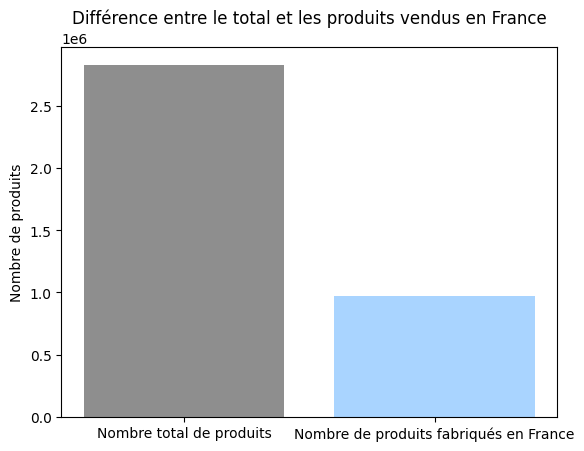

In [3]:
# Drop rows with the selling countries are not known
df = df.dropna(subset=['countries_tags'])


# Filter the rows with only countries_tags that contains 'france'
france_df = df[df['countries_tags'].str.contains('france')]
france_df = france_df[cols]
france_df_length = len(france_df)
formatted_france_df_length = format(france_df_length, ',').replace(',', ' ')
france_df = france_df.drop_duplicates()
france_df_uniques_length = len(france_df)
print(f"{france_df_length - france_df_uniques_length} lignes étaient des doublons parfaits.")
print(f"Au total, il y avait {formatted_total_df_length} lignes dans la base initiale. \nAprès avoir gardé seulement les produits vendus en France, il y a {formatted_france_df_length}, soit {round(france_df_length/total_df_length* 100,2)} % de la base initiale.")

# GRAPH
values = [total_df_length, france_df_length]
labels = ["Nombre total de produits", "Nombre de produits fabriqués en France"]
fig, ax = plt.subplots()
ax.bar(labels, values, color=['#8E8E8E', '#A9D4FF'])
ax.set_ylabel('Nombre de produits')
ax.set_title('Différence entre le total et les produits vendus en France')

plt.show()

#### Erreurs lexicales

In [17]:
# check if there are two different data types in each column
for col in france_df.columns:
    if france_df[col].nunique() > 1:
        print(f"{col} : {france_df[col].dtypes}")
        
print("\nOn peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.")

code : object
product_name : object
main_category_fr : object
countries_tags : object
manufacturing_places_tags : object
nutriscore_score : float64
nutriscore_grade : object
ecoscore_score : float64
ecoscore_grade : object
additives_n : float64
carbon-footprint_100g : float64
sugars_100g : float64
fat_100g : float64
saturated-fat_100g : float64
sodium_100g : float64

On peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.


#### Gestion des valeurs nulles
##### Basiques

In [27]:
filled_pct = (france_df.isna().sum() / len(df) * 100)
print(filled_pct)

# Remove the lines which do not have product_name
france_df.dropna(subset=['product_name'], inplace=True)

code                          0.000000
product_name                  0.000000
main_category_fr             16.594018
countries_tags                0.000000
manufacturing_places_tags    30.396940
nutriscore_score             20.599925
nutriscore_grade             20.599925
ecoscore_score               21.312726
ecoscore_grade               21.312726
additives_n                  23.408830
carbon-footprint_100g        33.359036
sugars_100g                   7.100378
fat_100g                      7.255689
saturated-fat_100g            7.086385
sodium_100g                   8.590649
dtype: float64


On peut voir qu'il y a des produits qui n'ont pas de nom. Nous n'avons pas vraiment d'autre choix que de les supprimer. (cf. ligne au-dessus)

#### Variables qualitatives

Dans notre cas, nous allons avoir essentiellement besoin du **Nutriscore** et de l'**Eco-score**. \
Si ces deux valeurs ne sont pas présentes, nous allons essayer de les déduire grâce aux informations nutritionnelles et écologiques présentes pour le produit.
Nous allons donc éliminer les valeurs où tous les champs : `['nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']` sont nuls. \
Si une valeur est présente, nous gardons la ligne pour le moment pour essayer de la déduire. \

En lançant une fois la fonction dropna, nous vyons que l'ecoscore grade est à unknown est pas forcément à nul.
Je vais donc voir quelles sont les valeurs des ecoscore_grade et nutriscore_grade

In [7]:
def remove_quant_var_null_values():
    without_all_characteristics_nan_df = france_df.dropna(subset=['carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g'], thresh=1)
    without_all_characteristics_nan_df_length = len(without_all_characteristics_nan_df)
    formatted_without_all_characteristics_nan_df_length = format(without_all_characteristics_nan_df_length, ',').replace(',', ' ')
    print(f"Il y avait {formatted_france_df_length} produits, après ce nettoyage il y en a : {formatted_without_all_characteristics_nan_df_length}.")
    return without_all_characteristics_nan_df

remove_quant_var_null_values()

Il y avait 970 916 produits, après ce nettoyage il y en a : 787 122.


,code,product_name,main_category_fr,countries_tags,manufacturing_places_tags,nutriscore_score,nutriscore_grade,ecoscore_score,ecoscore_grade,additives_n,carbon-footprint_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
3,00000000000026772226,Skyr,Fromages à la crème,en:france,NaN,-5.0,a,34.0,d,NaN,NaN,3.900000,0.20000,0.100000,0.036000
4,0000000000017,Vitória crackers,NaN,en:france,NaN,NaN,NaN,NaN,unknown,NaN,NaN,15.000000,7.00000,3.080000,0.560000
11,0000000000100,moutarde au moût de raisin,en:groceries,en:france,NaN,18.0,d,54.0,c,0.0,NaN,22.000000,8.20000,2.200000,1.840000
12,0000000000123,Sauce Sweety chili 0%,NaN,en:france,NaN,NaN,NaN,NaN,unknown,NaN,NaN,0.400000,0.00000,0.000000,0.816000
13,0000000000178,Mini coco,NaN,en:france,NaN,NaN,NaN,NaN,unknown,NaN,NaN,3.000000,3.00000,1.000000,0.460000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829816,3248451073878,Puree De Courgettes Carottes Jaunes Boursin D'...,Purées de courgettes,"en:belgium,en:france",NaN,-5.0,a,81.0,a,0.0,NaN,3.600000,1.50000,1.000000,0.204000
2829817,3292590606497,Instant feerique,Desserts glacés,en:france,NaN,14.0,d,NaN,unknown,15.0,NaN,32.000000,10.00000,5.900000,0.080000
2829818,35033264,DooWap,Brioches,en:france,NaN,13.0,d,44.0,c,NaN,NaN,16.400000,12.10000,3.900000,0.352000
2829819,39240958,Doowap,Brioches,en:france,NaN,13.0,d,44.0,c,NaN,NaN,16.600000,11.50000,3.300000,0.292000


In [8]:
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df[col].unique()}")

nutriscore_grade : [nan 'a' 'd' 'b' 'c' 'e']
ecoscore_grade : ['unknown' 'd' 'c' 'b' 'e' 'not-applicable' 'a' nan]


Pour le nutriscore, pas de problème.\
Pour l'eco-score, nous avons deux valeurs qui ne sont pas utilisables : unknown et and not-applicable. Nous les remplacerons par nan. \
Nous relançons ensuite la même fonction que précédement.

In [10]:
france_df['ecoscore_grade'] = france_df['ecoscore_grade'].replace(['unknown', 'not-applicable'], np.nan)
df_with_cleaned_qualitative_var = remove_quant_var_null_values()
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df[col].unique()}")


Il y avait 970 916 produits, après ce nettoyage il y en a : 787 122.
nutriscore_grade : [nan 'a' 'd' 'b' 'c' 'e']
ecoscore_grade : [nan 'd' 'c' 'b' 'e' 'a']


Ce n'a pas eu trop d'effet. Néanmoins maintenant les colonnes sont uniformes.\
#### Variables quantitatives
Attaquons nous maintenant aux variables quantitatives. Il s'agit des colonnes `['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'carbon-footprint_100g']`. \
Toutes ces variables sont sensées être des proportions sur 100g. Elles ne doivent donc être ni négatives, ni supérieures à 100. Voyons voir la répartition.

In [36]:
# define the bins
bins = [-float('inf'), 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]

# loop over each column
for col in ['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'carbon-footprint_100g']:
    cut_series = pd.cut(df_with_cleaned_qualitative_var[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'sugars_100g':
sugars_100g
(-inf, 0.0]       93326
(0.0, 10.0]      398950
(10.0, 20.0]      73192
(20.0, 30.0]      52524
(30.0, 40.0]      36081
(40.0, 50.0]      29473
(50.0, 60.0]      31556
(60.0, 70.0]      13945
(70.0, 80.0]       9441
(80.0, 90.0]       4367
(90.0, 100.0]      3463
(100.0, inf]         19
Name: count, dtype: int64

Value counts for column 'fat_100g':
fat_100g
(-inf, 0.0]       79753
(0.0, 10.0]      329923
(10.0, 20.0]     125301
(20.0, 30.0]     101530
(30.0, 40.0]      57427
(40.0, 50.0]      19469
(50.0, 60.0]      10457
(60.0, 70.0]       3860
(70.0, 80.0]       2662
(80.0, 90.0]       1857
(90.0, 100.0]      9681
(100.0, inf]         30
Name: count, dtype: int64

Value counts for column 'saturated-fat_100g':
saturated-fat_100g
(-inf, 0.0]      121918
(0.0, 10.0]      478517
(10.0, 20.0]     108555
(20.0, 30.0]      31117
(30.0, 40.0]       2746
(40.0, 50.0]        679
(50.0, 60.0]       2141
(60.0, 70.0]        262
(70.0, 80.0]     

In [59]:
pd.set_option("display.max_rows", None)
france_df.sample(100)

,code,product_name,main_category_fr,countries_tags,manufacturing_places_tags,nutriscore_score,nutriscore_grade,ecoscore_score,ecoscore_grade,additives_n,carbon-footprint_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
1144921,3251516420005,La délicieuse coco exotique,Gâteaux et pâtisseries surgelés,en:france,france,19.0,e,NaN,NaN,NaN,NaN,26.000000,17.000000,11.000000,0.044000
1192974,3270720444959,Mix cerises,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.500000,21.900000,3.000000,0.004000
2417358,8054619495261,Aranciata Rossa,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,0.000000,0.000000,0.000000
2132926,7610900052608,"Cristallina Vanille Jogurt, Milch, Zucker",Yaourts à la grecque,"en:france,en:switzerland",NaN,2.0,b,NaN,NaN,2.0,NaN,13.000000,3.000000,1.000000,0.000000
1037413,29061921,Fleischspieße,NaN,"en:france,en:germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667558,4062300259669,Käse-makkaroni Mit Gemüse,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400000,3.500000,0.700000,0.052000
1384052,3596710422517,Nappage caramel au beurre salé,Caramel liquide,en:france,NaN,17.0,d,NaN,NaN,4.0,NaN,60.400000,4.000000,2.400000,0.200000
424537,0203110019355,Brioche,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.600000,11.000000,7.100000,0.480000
904407,2227143023293,Jambon cuit italien rôti aux herbes,Jambons blancs,en:france,NaN,12.0,d,12.0,e,NaN,NaN,0.600000,9.000000,3.300000,0.720000
1080732,3102870002065,Cardamome verte entière,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
